In [1]:
!pip install -q ultralytics insightface opencv-python onnxruntime
!pip install -U insightface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s et

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np
import PIL.Image
import io
import base64


def take_photo(filename='face.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📷 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize video
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto({quality: %s});
    ''' % quality)

    display(js)
    data = eval_js("takePhoto({quality: %f})" % quality)
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    img = PIL.Image.open(io.BytesIO(binary))
    return img

In [3]:
image = take_photo()
image.show()

<IPython.core.display.Javascript object>

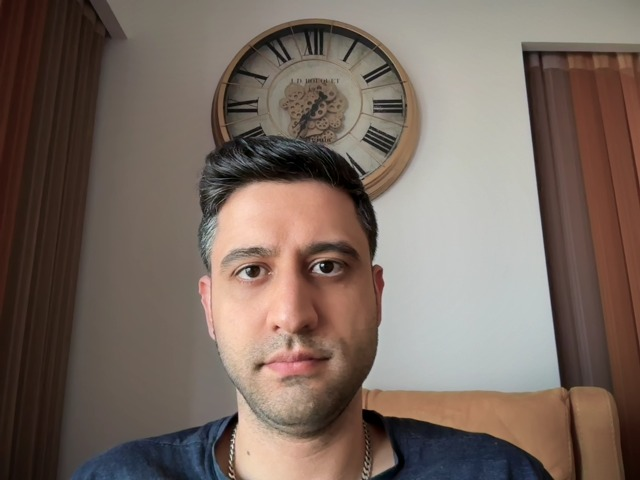

In [9]:
display(image)

In [4]:
import cv2
import insightface
from insightface.app import FaceAnalysis
import pickle
import numpy as np

In [7]:
app = FaceAnalysis(name='buffalo_l', providers = ['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:03<00:00, 81252.12KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [11]:
img = cv2.imread("face.jpg")

faces = app.get(img)

if not faces:
  print("No face detected.")
else:
  face = faces[0]
  emb = face.embedding
  print("Face is detected and embedded")

Face is detected and embedded


In [20]:
import os

# Ask user for a label
name = input("Enter name for this face: ")

# Prepare path and load existing embeddings
db_path = "face_db.pkl"
if os.path.exists(db_path):
    with open(db_path, "rb") as f:
        face_db = pickle.load(f)
else:
    face_db = {}

# Add new face
face_db[name] = emb

# Save updated database
with open(db_path, "wb") as f:
    pickle.dump(face_db, f)

print(f"✅ Saved embedding for {name}")

Enter name for this face: Amir
✅ Saved embedding for Amir


In [21]:
# Assume you just captured and detected a face from webcam
image = cv2.imread("face.jpg")  # OR convert PIL image to cv2 if needed
faces = app.get(image)

if faces:
    embedding = faces[0].embedding
    name = "Amir"  # Replace with user input later
    face_db = {}
    face_db[name] = embedding
    print("✅ Face added to database.")
else:
    print("❌ No face detected.")

✅ Face added to database.


In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import numpy as np

# ⬅️ Assume face_db already exists (dictionary with name: embedding)
# Example: face_db = {'Amir': embedding_array}

def recognize_face_and_open_door(face_db, threshold=0.5):
    print("📸 Capturing new face for recognition...")
    take_photo("input.jpg")
    img = cv2.imread("input.jpg")
    faces = app.get(img)

    if not faces:
        print("❌ No face detected.")
        return

    # Extract embedding from new capture
    new_emb = faces[0].embedding.reshape(1, -1)

    # Compare with all embeddings in DB
    max_score = 0
    identified_name = None
    for name, saved_emb in face_db.items():
        saved_emb = saved_emb.reshape(1, -1)
        score = cosine_similarity(new_emb, saved_emb)[0][0]
        if score > max_score:
            max_score = score
            identified_name = name

    # Result
    print(f"🧠 Highest Similarity: {max_score:.4f} → Match: {identified_name if max_score > threshold else 'Unknown'}")

    if max_score > threshold:
        print(f"🔓 Door opened for: {identified_name} ✅")
    else:
        print("⛔ Access Denied ❌")

In [23]:
recognize_face_and_open_door(face_db)

📸 Capturing new face for recognition...


<IPython.core.display.Javascript object>

🧠 Highest Similarity: 0.9247 → Match: Amir
🔓 Door opened for: Amir ✅
